# Fractional Differentiation

- 가격과 같은 비정상성의(non-stationary) 시계열 자료는 통계모형 등의 분석에 적합하지 않다. 따라서 보통 시계열 자료를 (정수 단위로; 1차, 2차 ...) 차분하여 정상적(stationary) 상태로 만들어 분석에 사용한다.

- 시계열이 비정상성이라는 것은 그만큼 메모리(memory)를 보존하고 있다는 것이다. 따라서 과도하게 차분을 하여 시계열을 정상적으로 만들면 기존의 시계열 자료가 가지고 있는 정보는 사라지게 된다.

- 이를 방지하기 위한 방법이 분수 차분(fractional differentiation)이다. "fractional differentiation"은 M.DePrado의 저서 "Advances in Financial Machine Learning"에 소개된 방법으로 시계열의 메모리를 어느정도 보존하면서 정상성을 만족하도록 차분해주는 것을 의미한다.

## 방법 *(작성중)*

다음과 같은 Backshift 연산자 $B$가 있다고 하자

실수 행렬 ${Xt}$에 대해 
- $B^k X_t = X_{t−k}$ ($k \geq 0$)

## 예시

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import fracdiff # https://github.com/fracdiff/fracdiff를 사용

In [2]:
# S&P500 지수를 가져와본다

sp500 = yf.download('^GSPC', start='2001-1-1').Close

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

Date
2001-01-02    1283.270020
2001-01-03    1347.560059
2001-01-04    1333.339966
2001-01-05    1298.349976
2001-01-08    1295.859985
                 ...     
2023-04-21    4133.520020
2023-04-24    4137.040039
2023-04-25    4071.629883
2023-04-26    4055.989990
2023-04-27    4135.350098
Name: Close, Length: 5615, dtype: float64

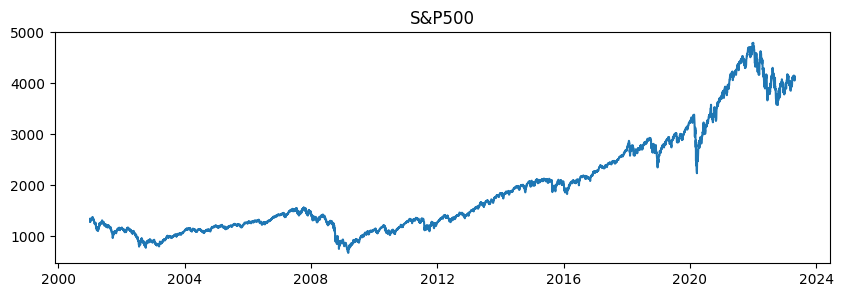

In [4]:
plt.figure(figsize=(10,3))
plt.title("S&P500")
plt.plot(sp500)
plt.show()

In [5]:
# fraction difference (n=1)은 np.diff()와 같다.

diff = sp500.diff()[1:]
f_diff_1 = fracdiff.fdiff(sp500, n=1)
np.all(diff == f_diff_1)

True

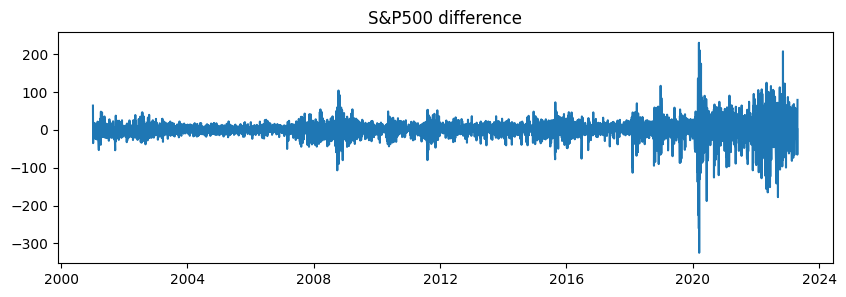

In [6]:
diff = sp500.diff()
plt.figure(figsize=(10,3))
plt.title("S&P500 difference")
plt.plot(diff)
plt.show()

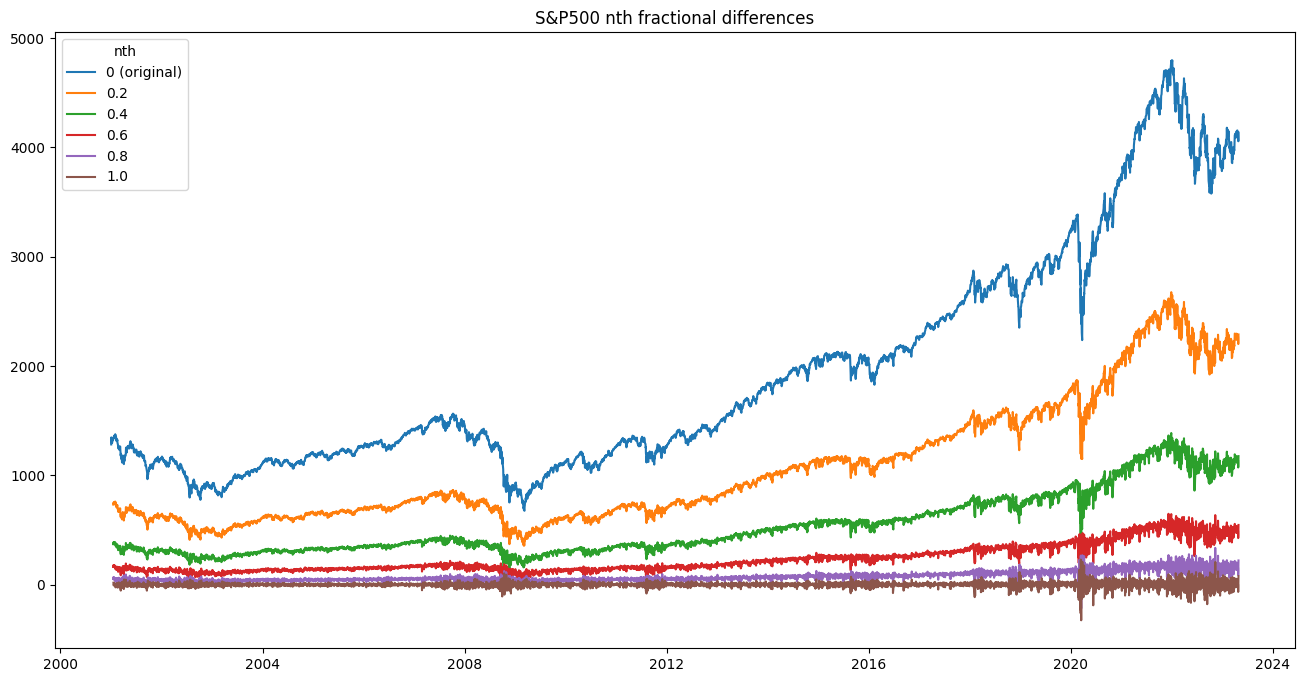

In [7]:
n_s=[.2,.4,.6,.8,1.]
w=10
plt.figure(figsize=(16,8))
plt.title(f"S&P500 nth fractional differences")
plt.plot(sp500)
for n in n_s:
    diff = fracdiff.fdiff(sp500, n=n, window=w)[w:]
    diff = pd.Series(diff,index=sp500.index[int(n)+w:])
    plt.plot(diff)
plt.legend(['0 (original)']+n_s, title='nth')
plt.savefig("fdiff_thumbnail.jpg")
plt.show()